# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
from jax import numpy as np
#import numpy as np
import pickle
import math

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from calibrate import calibrate
from utils import read_diagrams, create_labeled_classes, bin_class_loss, multi_class_loss, bin_class_acc, multi_class_acc, visualize_results

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Uncomment if you do not want to access GPU
#os.environ["JAX_PLATFORMS"] = "cpu"

BATCH_SIZE = 64
EPOCHS = 1000
SEED = 0

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 3200
}

## Select workload and read the circuits

Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
workload_size = "medium"
#workload_size = "large"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1
loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

We read the circuits from the pickled files.

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training, validation and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Prepare circuits for the Lambeq optimizer

## Continuously optimize parameters

In [5]:
def get_symbols(circs):
    return set([sym for circuit in circs.values() for sym in circuit.free_symbols])


def construct_data_and_labels(circuits, labels):
    circuits_l = []
    data_labels_l = []
    for key in circuits:
        circuits_l.append(circuits[key])
        data_labels_l.append(labels[key])
    return circuits_l, data_labels_l


def select_circuits(base_circuits, selected_circuits):
    res = {}
    syms = get_symbols(base_circuits)
    for c in selected_circuits:
        s_syms = set(selected_circuits[c].free_symbols)
        if s_syms.difference(syms) == set():
            res[c] = selected_circuits[c]
    return res

Progress:  0.0
Number of training circuits: 2    Number of validation circuits: 1    Number of test circuits: 1    Number of parameters in model: 42


Epoch 1:     train/loss: 1.4869   valid/loss: 0.7838   train/acc: 0.0000   valid/acc: 0.0000
Epoch 100:   train/loss: 0.0894   valid/loss: 0.1554   train/acc: 1.0000   valid/acc: 1.0000
Epoch 200:   train/loss: 0.0290   valid/loss: 0.0797   train/acc: 1.0000   valid/acc: 1.0000
Epoch 300:   train/loss: 0.0194   valid/loss: 0.0204   train/acc: 1.0000   valid/acc: 1.0000
Epoch 400:   train/loss: 0.0039   valid/loss: 0.0075   train/acc: 1.0000   valid/acc: 1.0000
Epoch 500:   train/loss: 0.0081   valid/loss: 0.0044   train/acc: 1.0000   valid/acc: 1.0000
Epoch 600:   train/loss: 0.0154   valid/loss: 0.0030   train/acc: 1.0000   valid/acc: 1.0000
Epoch 700:   train/loss: 0.0047   valid/loss: 0.0031   train/acc: 1.0000   valid/acc: 1.0000
Epoch 800:   train/loss: 0.0075   valid/loss: 0.0024   train/acc: 1.0000   valid/acc: 1.0000
Epoch 900:   train/loss: 0.0086   valid/loss: 0.0023   train/acc: 1.0000   valid/acc: 1.0000
Epoch 1000:  train/loss: 0.0111   valid/loss: 0.0018   train/acc: 1.00

Test accuracy: 0.0
Progress:  0.01
Number of training circuits: 3    Number of validation circuits: 3    Number of test circuits: 1    Number of parameters in model: 46


Epoch 1:     train/loss: 0.5532   valid/loss: 0.5376   train/acc: 0.6667   valid/acc: 1.0000
Epoch 100:   train/loss: 0.1058   valid/loss: 0.7625   train/acc: 1.0000   valid/acc: 0.6667
Epoch 200:   train/loss: 0.0595   valid/loss: 1.0818   train/acc: 1.0000   valid/acc: 0.6667
Epoch 300:   train/loss: 0.0485   valid/loss: 1.1990   train/acc: 1.0000   valid/acc: 0.6667
Epoch 400:   train/loss: 0.0306   valid/loss: 2.3217   train/acc: 1.0000   valid/acc: 0.3333
Epoch 500:   train/loss: 0.0232   valid/loss: 3.1013   train/acc: 1.0000   valid/acc: 0.3333
Epoch 600:   train/loss: 0.0210   valid/loss: 1.4943   train/acc: 1.0000   valid/acc: 0.6667
Epoch 700:   train/loss: 0.4151   valid/loss: 1.0632   train/acc: 0.6667   valid/acc: 0.6667
Epoch 800:   train/loss: 0.0379   valid/loss: 1.1388   train/acc: 1.0000   valid/acc: 0.6667
Epoch 900:   train/loss: 0.0193   valid/loss: 1.2211   train/acc: 1.0000   valid/acc: 0.6667
Epoch 1000:  train/loss: 0.0202   valid/loss: 1.4150   train/acc: 1.00

Test accuracy: 0.0
Progress:  0.03
Number of training circuits: 4    Number of validation circuits: 7    Number of test circuits: 4    Number of parameters in model: 49


Epoch 1:     train/loss: 0.8429   valid/loss: 0.3333   train/acc: 0.7500   valid/acc: 1.0000
Epoch 100:   train/loss: 0.3093   valid/loss: 0.6257   train/acc: 0.7500   valid/acc: 0.4286
Epoch 200:   train/loss: 0.2558   valid/loss: 0.6113   train/acc: 1.0000   valid/acc: 0.4286
Epoch 300:   train/loss: 0.2330   valid/loss: 0.6724   train/acc: 1.0000   valid/acc: 0.4286
Epoch 400:   train/loss: 0.1831   valid/loss: 0.7955   train/acc: 1.0000   valid/acc: 0.4286
Epoch 500:   train/loss: 0.1542   valid/loss: 0.9346   train/acc: 1.0000   valid/acc: 0.4286
Epoch 600:   train/loss: 0.1278   valid/loss: 1.0378   train/acc: 1.0000   valid/acc: 0.4286
Epoch 700:   train/loss: 0.1360   valid/loss: 1.0268   train/acc: 1.0000   valid/acc: 0.5714
Epoch 800:   train/loss: 0.1906   valid/loss: 1.0946   train/acc: 1.0000   valid/acc: 0.5714
Epoch 900:   train/loss: 0.0925   valid/loss: 1.0473   train/acc: 1.0000   valid/acc: 0.5714
Epoch 1000:  train/loss: 0.0829   valid/loss: 1.0550   train/acc: 1.00

Test accuracy: 0.5
Progress:  0.04
Number of training circuits: 5    Number of validation circuits: 10    Number of test circuits: 5    Number of parameters in model: 52


Epoch 1:     train/loss: 0.8815   valid/loss: 0.4895   train/acc: 0.6000   valid/acc: 0.9000
Epoch 100:   train/loss: 0.3496   valid/loss: 0.6631   train/acc: 0.8000   valid/acc: 0.6000
Epoch 200:   train/loss: 0.1358   valid/loss: 1.9429   train/acc: 1.0000   valid/acc: 0.4000
Epoch 300:   train/loss: 0.0878   valid/loss: 2.2961   train/acc: 1.0000   valid/acc: 0.4000
Epoch 400:   train/loss: 0.0791   valid/loss: 2.3407   train/acc: 1.0000   valid/acc: 0.4000
Epoch 500:   train/loss: 0.1652   valid/loss: 2.6874   train/acc: 1.0000   valid/acc: 0.4000
Epoch 600:   train/loss: 0.0741   valid/loss: 2.5425   train/acc: 1.0000   valid/acc: 0.4000
Epoch 700:   train/loss: 0.0702   valid/loss: 2.5883   train/acc: 1.0000   valid/acc: 0.4000
Epoch 800:   train/loss: 0.0469   valid/loss: 2.7591   train/acc: 1.0000   valid/acc: 0.4000
Epoch 900:   train/loss: 0.0641   valid/loss: 2.6817   train/acc: 1.0000   valid/acc: 0.4000
Epoch 1000:  train/loss: 0.0660   valid/loss: 2.9430   train/acc: 1.00

Test accuracy: 0.8
Progress:  0.05
Number of training circuits: 6    Number of validation circuits: 18    Number of test circuits: 15    Number of parameters in model: 70


Epoch 1:     train/loss: 1.3332   valid/loss: 1.1942   train/acc: 0.3333   valid/acc: 0.2778
Epoch 100:   train/loss: 0.3685   valid/loss: 0.8199   train/acc: 0.8333   valid/acc: 0.7222
Epoch 200:   train/loss: 0.3406   valid/loss: 0.8226   train/acc: 0.8333   valid/acc: 0.7222
Epoch 300:   train/loss: 0.3346   valid/loss: 0.8247   train/acc: 0.8333   valid/acc: 0.7222
Epoch 400:   train/loss: 0.3340   valid/loss: 0.8480   train/acc: 0.8333   valid/acc: 0.7222
Epoch 500:   train/loss: 0.3292   valid/loss: 0.8516   train/acc: 0.8333   valid/acc: 0.7222
Epoch 600:   train/loss: 0.3364   valid/loss: 0.8524   train/acc: 0.8333   valid/acc: 0.7222
Epoch 700:   train/loss: 0.3307   valid/loss: 0.8421   train/acc: 0.8333   valid/acc: 0.7222
Epoch 800:   train/loss: 0.3204   valid/loss: 0.8405   train/acc: 0.8333   valid/acc: 0.7222
Epoch 900:   train/loss: 0.3275   valid/loss: 0.8511   train/acc: 0.8333   valid/acc: 0.7222
Epoch 1000:  train/loss: 0.3130   valid/loss: 0.8617   train/acc: 0.83

Test accuracy: 0.4666667
Progress:  0.06
Progress:  0.07
Progress:  0.09
Progress:  0.1
Progress:  0.11
Progress:  0.12
Progress:  0.14
Progress:  0.15
Progress:  0.16
Progress:  0.17
Progress:  0.19
Progress:  0.2
Progress:  0.21
Progress:  0.23
Number of training circuits: 20    Number of validation circuits: 21    Number of test circuits: 15    Number of parameters in model: 73


Epoch 1:     train/loss: 1.3086   valid/loss: 1.6876   train/acc: 0.4500   valid/acc: 0.5714
Epoch 100:   train/loss: 0.7021   valid/loss: 1.0418   train/acc: 0.5500   valid/acc: 0.3810
Epoch 200:   train/loss: 0.6107   valid/loss: 0.9639   train/acc: 0.5500   valid/acc: 0.5714
Epoch 300:   train/loss: 0.5841   valid/loss: 0.9152   train/acc: 0.6500   valid/acc: 0.6190
Epoch 400:   train/loss: 0.5530   valid/loss: 0.8815   train/acc: 0.8000   valid/acc: 0.6190
Epoch 500:   train/loss: 0.5350   valid/loss: 0.8881   train/acc: 0.6500   valid/acc: 0.5714
Epoch 600:   train/loss: 0.5429   valid/loss: 0.8948   train/acc: 0.7500   valid/acc: 0.6190
Epoch 700:   train/loss: 0.5464   valid/loss: 0.9038   train/acc: 0.7500   valid/acc: 0.6190
Epoch 800:   train/loss: 0.5274   valid/loss: 0.9086   train/acc: 0.8000   valid/acc: 0.6190
Epoch 900:   train/loss: 0.5116   valid/loss: 0.9128   train/acc: 0.8000   valid/acc: 0.6190
Epoch 1000:  train/loss: 0.5208   valid/loss: 0.9262   train/acc: 0.80

Test accuracy: 0.4666667
Progress:  0.24
Progress:  0.25
Progress:  0.26
Progress:  0.28
Progress:  0.29
Progress:  0.3
Progress:  0.31
Progress:  0.33
Number of training circuits: 28    Number of validation circuits: 21    Number of test circuits: 20    Number of parameters in model: 76


Epoch 1:     train/loss: 1.5917   valid/loss: 1.4680   train/acc: 0.3929   valid/acc: 0.5238
Epoch 100:   train/loss: 0.5536   valid/loss: 0.6832   train/acc: 0.6786   valid/acc: 0.6190
Epoch 200:   train/loss: 0.4641   valid/loss: 0.7205   train/acc: 0.7857   valid/acc: 0.6667
Epoch 300:   train/loss: 0.4479   valid/loss: 0.7502   train/acc: 0.7500   valid/acc: 0.6667
Epoch 400:   train/loss: 0.4019   valid/loss: 0.7784   train/acc: 0.7857   valid/acc: 0.6667
Epoch 500:   train/loss: 0.3946   valid/loss: 0.7748   train/acc: 0.8214   valid/acc: 0.6667
Epoch 600:   train/loss: 0.3909   valid/loss: 0.7624   train/acc: 0.8929   valid/acc: 0.6667
Epoch 700:   train/loss: 0.3749   valid/loss: 0.7577   train/acc: 0.8571   valid/acc: 0.6667
Epoch 800:   train/loss: 0.3713   valid/loss: 0.7543   train/acc: 0.8571   valid/acc: 0.6667
Epoch 900:   train/loss: 0.3635   valid/loss: 0.7492   train/acc: 0.8571   valid/acc: 0.6667
Epoch 1000:  train/loss: 0.3537   valid/loss: 0.7409   train/acc: 0.85

Test accuracy: 0.85
Progress:  0.34
Progress:  0.35
Progress:  0.36
Progress:  0.38
Progress:  0.39
Progress:  0.4
Progress:  0.41
Progress:  0.42
Progress:  0.44
Progress:  0.45
Progress:  0.46
Progress:  0.47
Progress:  0.49
Progress:  0.5
Progress:  0.51
Progress:  0.53
Progress:  0.54
Progress:  0.55
Progress:  0.56
Progress:  0.57
Progress:  0.59
Progress:  0.6
Progress:  0.61
Progress:  0.62
Progress:  0.64
Progress:  0.65
Progress:  0.66
Progress:  0.68
Progress:  0.69
Progress:  0.7
Progress:  0.71
Progress:  0.72
Progress:  0.74
Progress:  0.75
Progress:  0.76
Progress:  0.78
Progress:  0.79
Progress:  0.8
Progress:  0.81
Progress:  0.82
Progress:  0.84
Progress:  0.85
Progress:  0.86
Progress:  0.88
Progress:  0.89
Progress:  0.9
Progress:  0.91
Progress:  0.93
Progress:  0.94
Progress:  0.95
Progress:  0.96
Progress:  0.97


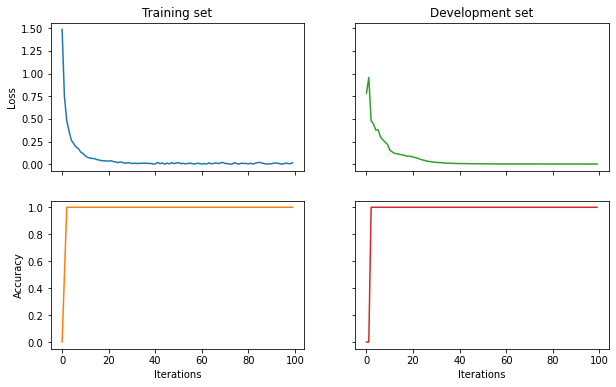

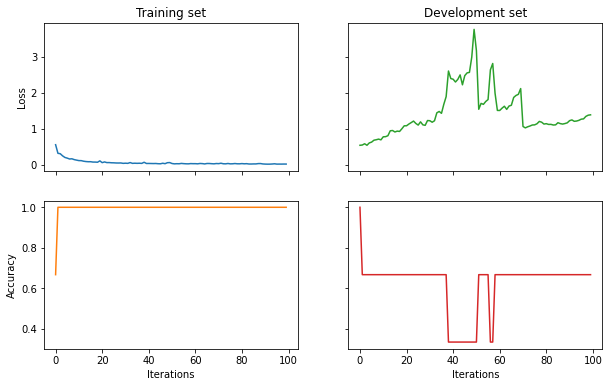

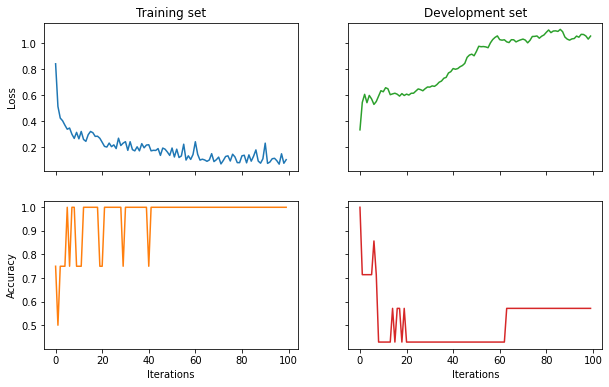

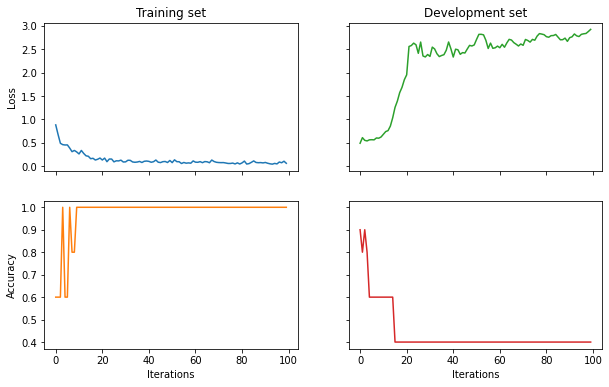

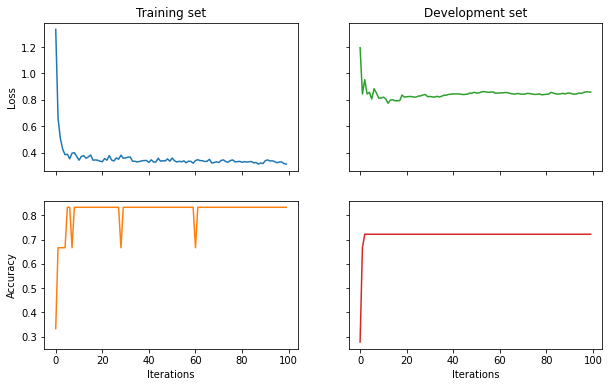

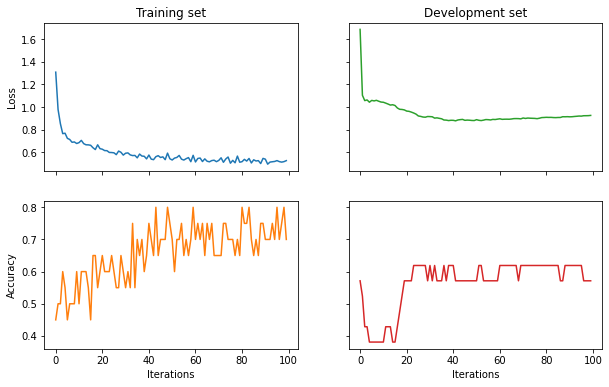

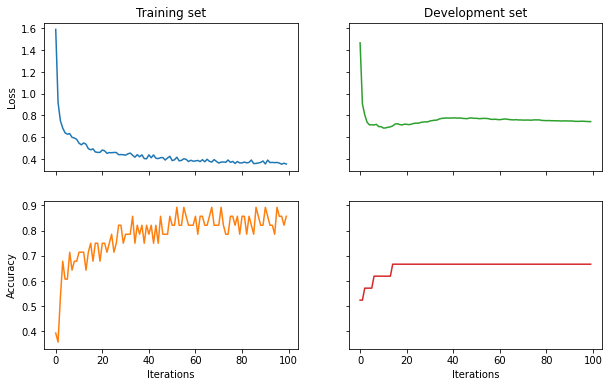

In [6]:
eval_metrics = {"acc": acc}
syms = {}

all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:1]

current_training_circuits = {}
for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]

for run, key in enumerate(all_training_keys[1:]):
    print("Progress: ", round(run/len(all_training_keys), 2))
    current_training_circuits[key] = training_circuits[key]
    
    if run == 0:
        syms = get_symbols(current_training_circuits)
    else:
        if len(syms) == len(get_symbols(current_training_circuits)):
            continue
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    print(f"Number of training circuits: {len(training_circuits_l)}   ",
          f"Number of validation circuits: {len(validation_circuits_l)}   ",
          f"Number of test circuits: {len(test_circuits_l)}   ",
          f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}")
    
    # Select model
    #model = TketModel.from_diagrams(training_circuits_l, backend_config = backend_config)
    model = NumpyModel.from_diagrams(training_circuits_l, use_jit=True)
    
    # Initialize the weights from the possible previous training checkpoint
    if run > 0:
        model.from_checkpoint(this_folder + "//training_checkpoints//" + workload + "//checkpoint_" + str(run - 1) + ".chk")
    else:
        model.initialise_weights()
    
    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a': 0.0053, 'c': 0.0185, 'A':0.01*EPOCHS},
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose = 'text',
        seed=SEED
        )
    
    train_dataset = Dataset(training_circuits_l, training_data_labels_l)
    val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)
    trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)
    checkpoint_path = this_folder + "//training_checkpoints//" + workload + "//checkpoint_" + str(run) + ".chk"
    model.make_checkpoint(checkpoint_path)
    visualize_results(model, trainer, test_circuits_l, test_data_labels_l, acc)
    syms = get_symbols(current_training_circuits)

## Select the model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

## Define loss function and evaluation metrics

## Initialize the trainer and the datasets

## Train the model and visualize